On the previous step the PTB XL data archive was downloaded to ../data directory.

For furher processing we need only:
- the files from the records500 folder
- ptbxl_database.csv

1) read raw ecg records and corresponding labels for each patient (label matches patient id)
2) extract qrs-complex segments from every ecg waveform

In [1]:
from os import path as Path
import pickle
import ast
from tqdm import tqdm
import wfdb
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from QRSDetectorOffline import QRSDetectorOffline

After reading the specifications of the dataset, and doing the research and data visualization, some parameters values were gotten to continue processing, as follows:
- sampling frequency of 500Hz (records500/)
- qrs segment length (qrs_duration)
- ecg signal bandwidth
- the number of extracted features/samples from an ecg

In [2]:
#constants
sampling_rate = 500 # sampling frequency of 500Hz (records500/)
qrs_threshold = 100
qrs_duration = 200
samples = 18
bandwidth = 2
    
ptbxl_path = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
processed_path = "../data"
ptbxl_db_file = Path.join(ptbxl_path, 'ptbxl_database.csv')

raw_data_ecg = Path.join(processed_path, 'raw500.npy')
ecg_file = Path.join(processed_path, 'X.pkl')
labels_file = Path.join(processed_path, 'Y.pkl')
ptbxl_qrs_file = Path.join(processed_path, 'processed_ptb_xl_data_' + str(samples) + '.pkl')

Load the raw ecg signals from /records500 directory. Every signal represented as 12-leads ecg and saved as 12 rows (each of the same length of 5000) in a binary file. For this experiment, just the first lead will be picked.

In [3]:
def load_raw_data(df) :
    """
    Load ecg signals data from WFDB Records. Note, that only the first of 12 leads will be picked.
    """
    if Path.exists(raw_data_ecg):
        with open(raw_data_ecg, 'rb') as f: data = pickle.load(f)
    else:
        print("Load raw ecg data from WFDB files...")
        data = []
        dt = [wfdb.rdsamp(Path.join(ptbxl_path, f)) for f in tqdm(df.filename_hr)]
        for signal, meta in dt :
            first_lead = signal[:,0] # take the first ecg lead for each patient
            # bandwidth filter
            if max(first_lead) > bandwidth or abs(min(first_lead)) > bandwidth : continue
            data.append(nk.ecg_clean(first_lead, sampling_rate=sampling_rate, method="pantompkins1985"))
    
        with open(raw_data_ecg, 'wb') as f: pickle.dump(data, f) 
                
    return data

Pick the first ecg lead for every patient keeping their labels or ids as well.
The important part of signal processing is __noise and outliers removing__. For this purpose there are a lot of filtering algorithms, for instance, the neurokit2 library is shipped with the special method - **ecg_clean** that will be used to improve ecg signals.
After filtering, the collected first-lead ecgs are saved to the binary file X.pkl,
the labels are saved to the Y.pkl.

In [4]:
def load_dataset() :
    """
    Loads PTB_XL raw signals data and saves it into binary format
    """
    # Load raw ecg data
    if Path.exists(ecg_file) and Path.exists(labels_file) :
        with open(ecg_file, 'rb') as f: X = pickle.load(f)
        with open(labels_file, 'rb') as f:  Y = pickle.load(f)
    else :
        # load and convert annotation data
        Y = pd.read_csv(ptbxl_db_file, index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
        
        # Load raw signal data
        X = load_raw_data(Y)
        
        pickle.dump(X, open(ecg_file, 'wb'))
        pickle.dump(Y, open(labels_file, 'wb'))
    
    return np.vstack(X), np.vstack(Y)

In order to make samples for every patient, their ecgs are broken into parts - so-called qrs segments. There are several algorithms do this, most of them are based on ecg R-peaks detection, because R-peak is the point of symmetry of QRS-complex. 

In [5]:
def find_peaks(ecg, ecg_id) :
    """
    Detect R-peaks for the given ecg by using the Pan-Tompkins algorithm.
    The borrowed algorithm implementation in the QRSDetectorOffline class turned out to work more precisely on
    the PTB XL data, than the ones, implemented in the neurokit2 package: 
        nk.detect_peaks(method="neurokit")
        https://github.com/neuropsychology/NeuroKit/blob/master/neurokit2/ecg/ecg_peaks.py
    """
    try :
        qrs_detector = QRSDetectorOffline(ecg, frequency=sampling_rate, ecg_id=ecg_id, verbose=False)
        
        return qrs_detector.detected_peaks_indices
    except :
        return []

In [6]:
def extract_qrs_segments(ecg, peaks) :
    """
    Extract qrs segments of the same length from the given ecg using the ecg R-peaks coordinates.
    """
    q_tmp = []
    cnt = 0
    
    if(len(peaks) >= samples) :
        for idx in peaks :
            data = ecg[idx-qrs_threshold : idx+qrs_threshold] # extract qrs segment by its peak
            if len(data) == qrs_duration and np.min(data) :
                q_tmp.append(data) # add qrs segment
                cnt += 1
            if cnt == samples : # the same samples count for each patient
                return np.array(q_tmp)
    
    return []


Detected R-peaks coordinates are pivot points for detecting qrs-complexes: to get qrs segment just take the same part of ecg signal before and after R peak point.

In [7]:
def extract_features() :
    """
    Detect r-peaks in raw ecg signals data and extract qrs segments along with corresponding class labels.
    """
    qrs_segments = []
    classes = []
    peaks_stats = { }
    
    if not Path.exists(ptbxl_qrs_file) :
        # Load raw ecg data
        x, y = load_dataset()

        for i in range(0, x.shape[0]) : # loop through all ecg records
            ecg = nk.signal_smooth(x[i], method="median")
            peaks_indices = find_peaks(ecg, i)
            qrs = extract_qrs_segments(ecg, peaks_indices)
            if len(qrs) == samples :
                qrs_segments.extend(qrs)
                classes.extend(i + 1 for _ in range(samples))
            #peaks_cnt = len(peaks_indices)
            #peaks_stats[peaks_cnt] = peaks_stats[peaks_cnt] + 1 if peaks_cnt in peaks_stats else 1
        with open(ptbxl_qrs_file, 'wb') as f: pickle.dump((qrs_segments, classes), f)
    else :
        with open(ptbxl_qrs_file, 'rb') as f: qrs_segments, classes = pickle.load(f)
    
    qrs_segments = np.array(qrs_segments)
    classes = np.array(classes)
    
    # show info about detected peaks counts
    #print(sorted(peaks_stats.items(), key=lambda x: x[1], reverse=True))
    
    return qrs_segments, classes

In [8]:
#x, y = load_dataset()
#print(x.shape)
#print(y.shape)
#plt.plot(np.linspace(0, x.shape[1], x.shape[0]), x) # 5000 ecg length, 21518 records
#plt.show()

To make sure that data was processed correctly, plot the diagrams of samples for some classes: the curves on the graphs must be in the form of a Q-, R- and S-wave.

Load raw ecg data from WFDB files...


100%|██████████| 21799/21799 [02:44<00:00, 132.13it/s]


QRS complex segments found: 14886 (from 827 patients, 18 samples per each)


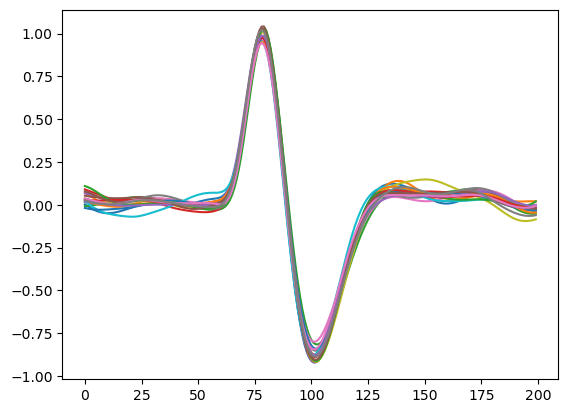

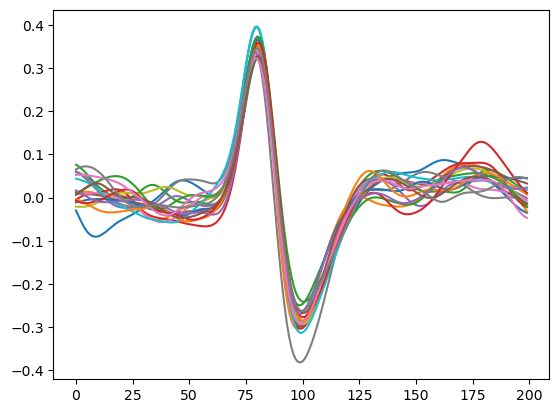

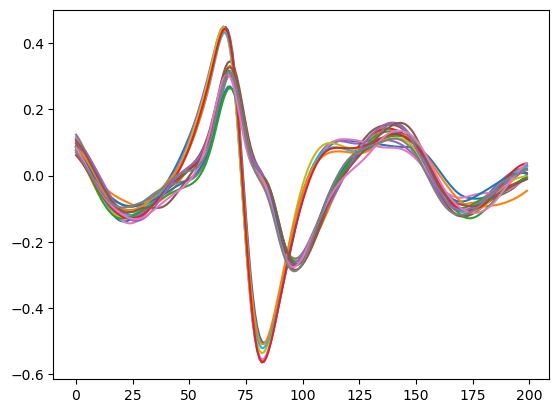

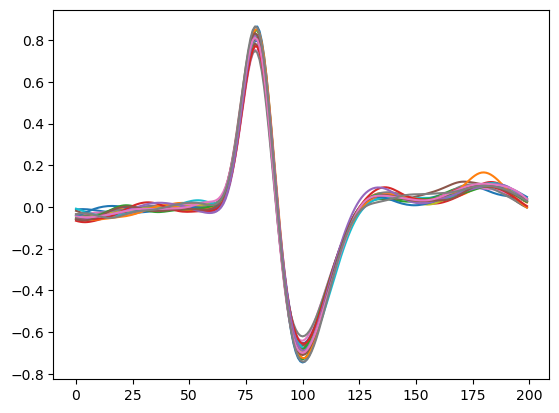

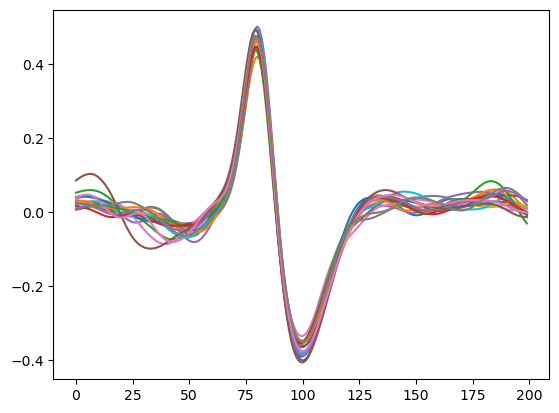

In [9]:
import random

qrs, classes = extract_features()
patients_count = int(qrs.shape[0] / samples)

# 18 samples per record - 14886 recors 827 classes
print(f"QRS complex segments found: {qrs.shape[0]} (from {patients_count} patients, {samples} samples per each)")
#print(classes.shape)

for i in random.sample(range(patients_count - 1), 5) :
    for curve in qrs[i*samples:(i+1)*samples] + qrs[-(i+1)*samples:-i*samples] : plt.plot(curve)
    plt.show()
